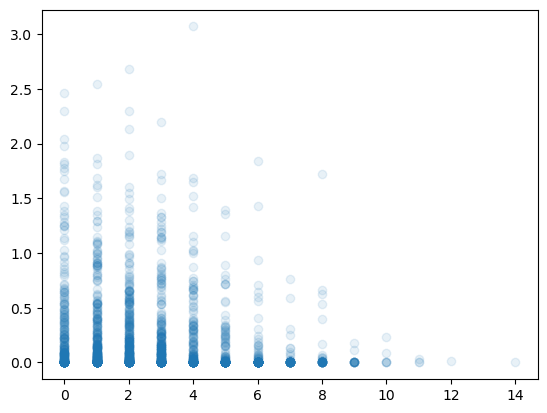

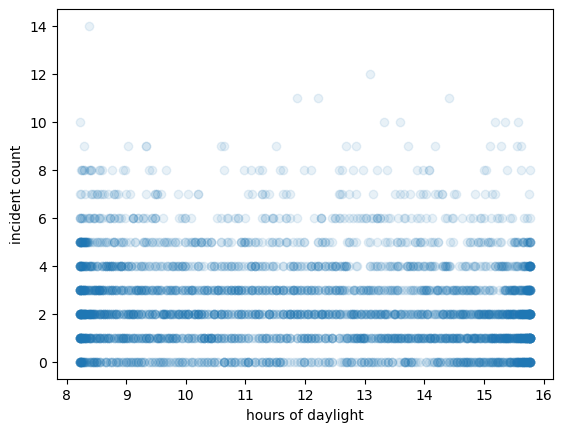

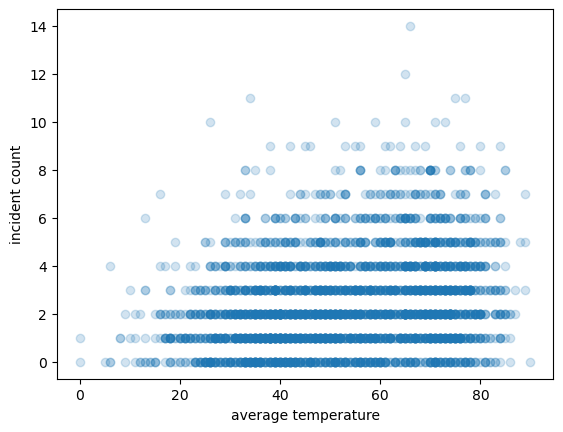

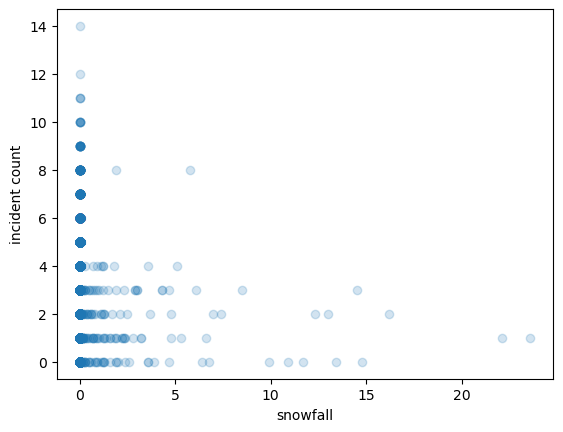

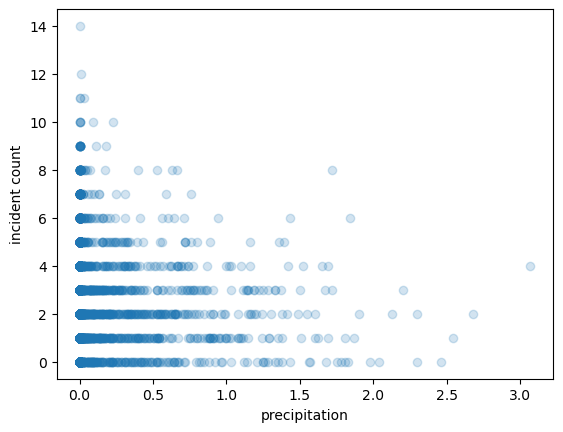

/var/folders/5x/1n063tsx6jx9wzcy34jzlqzh0000gn/T/ipykernel_38579/34638319.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_daily_weather = shots_daily_weather.groupby(['day_of_week']).mean().reset_index()


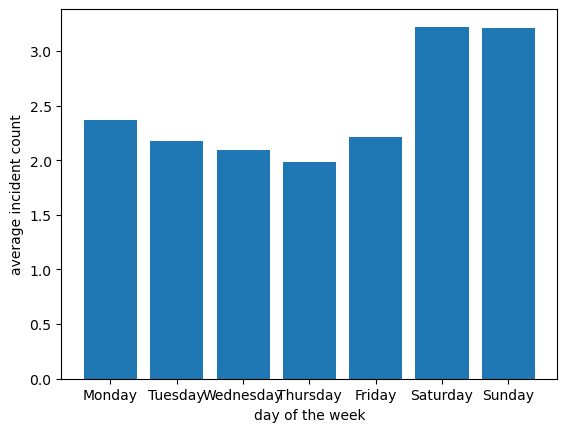

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

%run 'ShotsFired_EDA_aggregate_samples.ipynb'

In [2]:
# data lookin good
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours,day_of_week,weekend,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday
0,2015-01-01,14.32,0.00,0.0,26,C11A15,False,2.0,12.587640,Thursday,False,False,False,False,True,False,False,False
1,2015-01-02,12.75,0.00,0.0,34,B3E13,True,2.0,12.646087,Friday,False,False,False,False,False,True,False,False
2,2015-01-03,10.29,0.62,1.4,28,B2,False,1.0,12.704440,Saturday,True,False,False,False,False,False,True,False
3,2015-01-04,8.28,0.57,0.0,38,B2B2,True,2.0,12.762693,Sunday,True,False,False,False,False,False,False,True
4,2015-01-05,22.15,0.00,0.0,40,C6,False,1.0,12.820834,Monday,False,True,False,False,False,False,False,False


In [3]:
shot_count = 2

# let's rename all values: 10, 11, 12, 14 to 10+
shots_daily['incident_count'] = shots_daily['incident_count'].replace(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
    '2.0')

# let's rename 0 as 1
shots_daily['incident_count'] = shots_daily['incident_count'].replace(
    [0], 
    '1.0')

# looking at value counts, this should be move to the EDA notebook soon
print(shots_daily['incident_count'].value_counts())

incident_count
2.0    2806
1.0     465
Name: count, dtype: int64


In [4]:
# let's create X and y

X = shots_daily[['TAVG', 'PRCP', 'SNOW', 'AWND', 'daylight_hours', 
                 'is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday',
                   'is_Friday', 'is_Saturday', 'is_Sunday']]

# X = shots_daily[['AWND']]

y = shots_daily['incident_count']

print(X.shape)
print(y.shape)

(3271, 12)
(3271,)


In [5]:
# let's split our data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.15)

In [6]:
# now let's scale our data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# let's create a baseline model



In [7]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [8]:
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

X_train shape is (2780, 12)
y_train shape is (2780,)
X_test shape is (491, 12)
y_test shape is (491,)


In [9]:
# let's one-hot encode our y_train and y_test

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

print('y_train shape is', y_train.shape)
print('y_test shape is', y_test.shape)

y_train shape is (2780, 2)
y_test shape is (491, 2)


In [10]:
# y_train = keras.utils.to_categorical(y_train, shot_count)
# y_test = keras.utils.to_categorical(y_test, shot_count)

In [11]:
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

X_train shape is (2780, 12)
y_train shape is (2780, 2)
X_test shape is (491, 12)
y_test shape is (491, 2)


In [12]:
# let's run a linear regression using keras

model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(12,)),
    # keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='relu'),
    # keras.layers.Dropout(0.25),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),

    # let's add the output layer
    keras.layers.Dense(shot_count, activation='softmax')
    ])

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [14]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
)

callback_val_accuracy = keras.callbacks.EarlyStopping(
    monitor="vall_accuracy",
    patience=10,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=20,
    min_lr=0.0001
)

In [15]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train.argmax(axis=1))

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [16]:
batch_size = 16
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    class_weight=class_weights_dict,
                    validation_split=0.1
                    )

Epoch 1/100


157/157 [==============================] - 0s 1ms/step - loss: 0.6705 - accuracy: 0.6027 - val_loss: 0.7190 - val_accuracy: 0.5827 - lr: 0.0100
Epoch 2/100
157/157 [==============================] - 0s 525us/step - loss: 0.6434 - accuracy: 0.6910 - val_loss: 0.8050 - val_accuracy: 0.4640 - lr: 0.0100
Epoch 3/100
157/157 [==============================] - 0s 513us/step - loss: 0.6314 - accuracy: 0.6519 - val_loss: 0.6881 - val_accuracy: 0.6151 - lr: 0.0100
Epoch 4/100
157/157 [==============================] - 0s 510us/step - loss: 0.6262 - accuracy: 0.6819 - val_loss: 0.6715 - val_accuracy: 0.6151 - lr: 0.0100
Epoch 5/100
157/157 [==============================] - 0s 518us/step - loss: 0.6257 - accuracy: 0.6978 - val_loss: 0.7071 - val_accuracy: 0.6043 - lr: 0.0100
Epoch 6/100
157/157 [==============================] - 0s 507us/step - loss: 0.6240 - accuracy: 0.6986 - val_loss: 0.6323 - val_accuracy: 0.6727 - lr: 0.0100
Epoch 7/100
157/157 [==============================] - 0s 503us/st

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 2)                 22        
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# let's evaluate our model

model.evaluate(X_test, y_test, verbose=2)

16/16 - 0s - loss: nan - accuracy: 0.5092 - 15ms/epoch - 949us/step


[nan, 0.5091649889945984]

In [19]:
# recording our results
# 3 labels: 55.3% accuracy
# 4 labels: 31.66% accuracy
# 5 labels: 22.13% accuracy
# 6 labels: 20.78% accuracy
# 7 labels: 26% accuracy
# 8 labels: 24.8% accuracy
# 9 labels: 24.9% accuracy
# 10 labels: 24.8% accuracy
# 11 labels: 25.18% accuracy
# 12 labels: 25.67% accuracy
# 13 labels: 25.41% accuracy


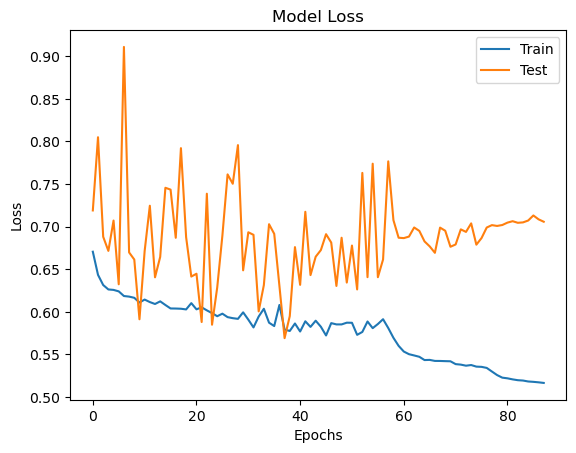

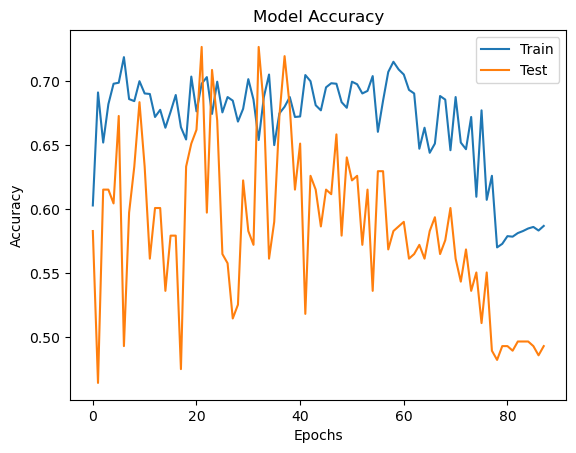

In [20]:
# let's plot our loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
# idea: we could try  and build models for every district, since different districts may have different trends
# we might be mixing too many trends here and that's why our model is not performing well

In [22]:
# let's make a confusion matrix

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

confusion_matrix(y_test, y_pred)

16/16 [==============================] - 0s 428us/step


array([[ 61,  39],
       [202, 189]])

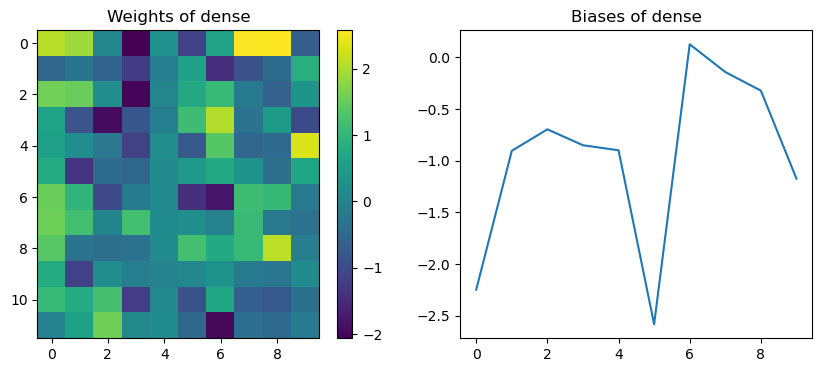

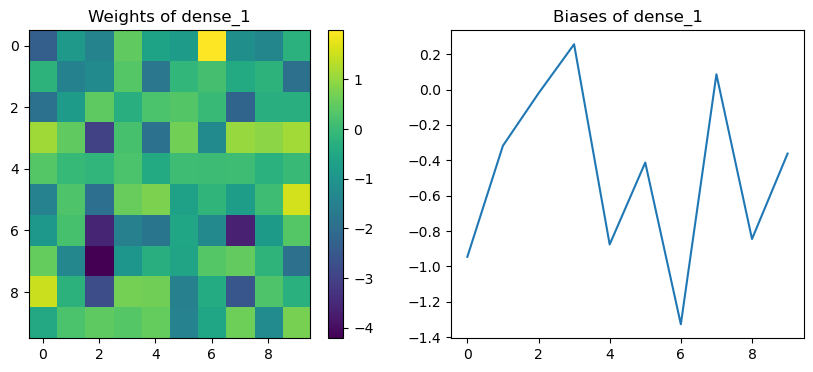

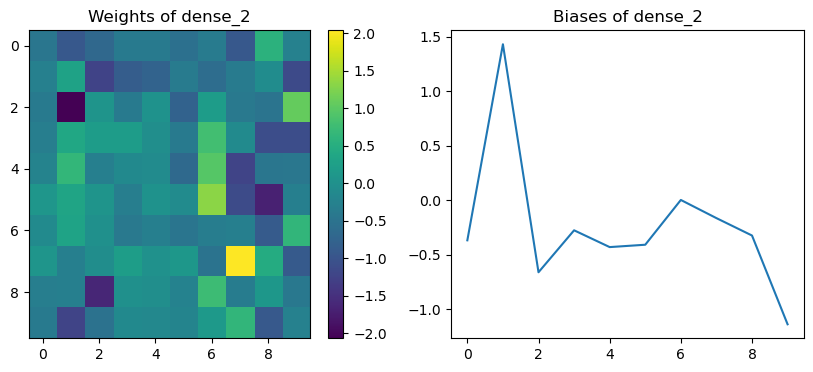

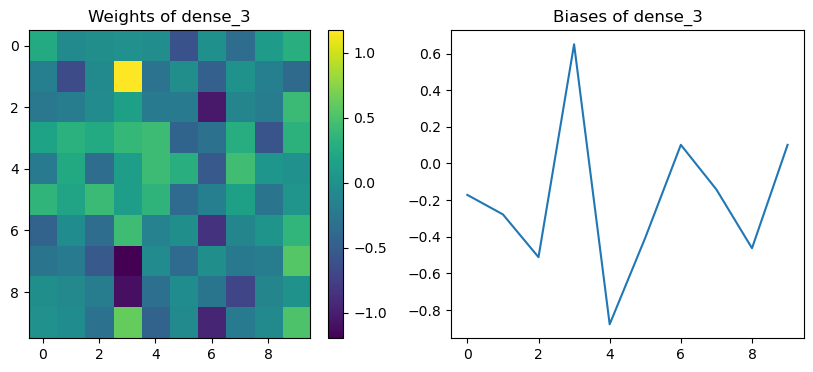

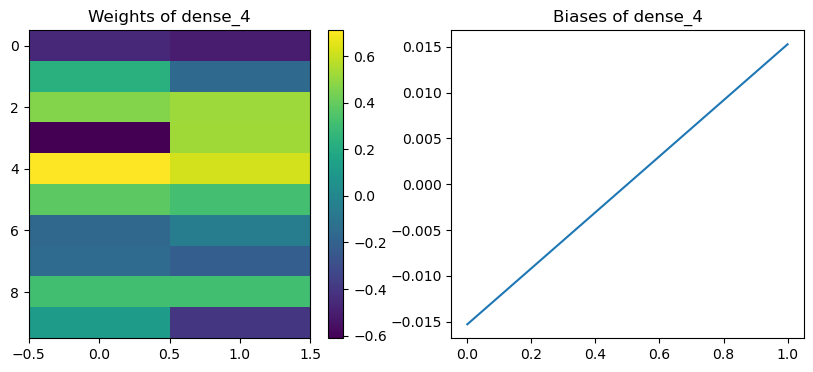

In [23]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Keras model
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        # weights[0] are the weights, weights[1] are the biases (if present)
        plt.figure(figsize=(10, 4))

        # Plotting the weights
        plt.subplot(1, 2, 1)
        plt.imshow(weights[0], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f"Weights of {layer.name}")

        # Plotting the biases if they exist
        if len(weights) > 1:
            plt.subplot(1, 2, 2)
            plt.plot(weights[1])
            plt.title(f"Biases of {layer.name}")

        plt.show()
